<a href="https://colab.research.google.com/github/QiLOL/CIS700-VGG16-Dog-Cat/blob/main/test2_continue_training_flipped_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train by flipped adv datset

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

!unzip -q train.zip -d .
!ls
!unzip -q test1.zip -d .
!ls

! ls train/ | wc -l
! ls test1/ | wc -l

Saving kaggle.json to kaggle.json
 97% 526M/543M [00:03<00:00, 195MB/s]
100% 543M/543M [00:03<00:00, 162MB/s]
100% 271M/271M [00:02<00:00, 169MB/s]
100% 271M/271M [00:02<00:00, 137MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 91.6MB/s]
kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train  train.zip
kaggle.json  sampleSubmission.csv  test1.zip  train.zip
sample_data  test1		   train
25000
12500


Label:(1)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


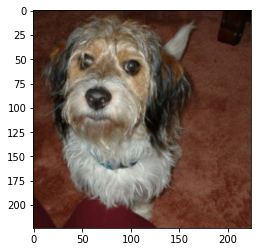

In [ ]:
# Librarys

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = "./train"
test_path ="./test1"
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
# FilePath List
train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg')) # the testset can be ingored we only use the trainset

# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# Dataset object
class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set, test_set = train_test_split(train_list, test_size=0.2, random_state=42) # to simplyfy the process using a fixed random seed

train_dataset = DogvsCatDataset(train_set, transform=ImageTransform(size, mean, std), phase='train')

test_dataset = DogvsCatDataset(test_set, transform=ImageTransform(size, mean, std), phase='test')

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:'+'(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

show_image(*train_dataset.__getitem__(0))

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# save to google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# load trained model
!cp drive/MyDrive/model_ori_trained2.pkl ./

In [ ]:
def model_init(model_, update_params_):
  params_to_update = []

  #TODO: change this to unfreeze the layer

  for name, param in model_.named_parameters():
      if name in update_params_:
          param.requires_grad = True
          params_to_update.append(param)
          print(name)
      else:
          param.requires_grad = False

  return params_to_update

net_ori_trained = torch.load('model_ori_trained2.pkl')
#update_params_name = ['classifier.6.weight', 'classifier.6.bias'] # change based on different model
update_params_name = ['features.0.weight', 'features.0.bias','classifier.6.weight', 'classifier.6.bias']
params_to_update = model_init(net_ori_trained, update_params_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias


In [ ]:
# load adversarial example dataset
!cp drive/MyDrive/adv_samples2_*_pure.pkl ./

In [ ]:
def test_model_f(net_, dataloader_input):
    

    net_.eval()
        
    epoch_loss = 0.0
    epoch_corrects = 0
    epoch_finish = 0
    
    for _id, (inputs, labels) in enumerate(tqdm(dataloader_input)):
        inputs = inputs.to(device)
        for tmp_i in range(len(labels)):
          if labels[tmp_i] == 0:
            labels[tmp_i] = 1
          else:
            labels[tmp_i] = 0
        labels = labels.to(device)
        optimizer.zero_grad()        
        outputs = net_(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data)
        epoch_finish += len(preds)

            
    epoch_loss = epoch_loss / len(dataloader_input.dataset)
    epoch_acc = epoch_corrects.double() / len(dataloader_input.dataset)
    
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

  

In [ ]:
def test_model(net_, dataloader_input):
    

    net_.eval()
        
    epoch_loss = 0.0
    epoch_corrects = 0
    epoch_finish = 0
    
    for _id, (inputs, labels) in enumerate(tqdm(dataloader_input)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()        
        outputs = net_(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data)
        epoch_finish += len(preds)

            
    epoch_loss = epoch_loss / len(dataloader_input.dataset)
    epoch_acc = epoch_corrects.double() / len(dataloader_input.dataset)
    
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [ ]:
adv_dataset_name = "adv_samples2_eps_1e-05_pure.pkl"
adv_dataset = torch.load(adv_dataset_name)
train_adv_set, test_adv_set = train_test_split(adv_dataset, test_size=0.2, random_state=42)
train_adv_dataloader = torch.utils.data.DataLoader(train_adv_set, shuffle=True, batch_size=32)
test_adv_dataloader = torch.utils.data.DataLoader(test_adv_set, shuffle=True, batch_size=32)

# test accuracy before training
test_model_f(net_ori_trained, test_adv_dataloader)
test_model(net_ori_trained, test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 0.3906 Acc: 1.0000



Loss: 0.0347 Acc: 0.9876


In [ ]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch, loss_dict):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        
        for phase in ['train', 'test']:
            _name = phase +str(epoch)
            loss_dict[_name] = []
            
            if phase == 'train':
                net.train()

            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            epoch_finish = 0
            
            for _id, (inputs, labels) in enumerate(tqdm(dataloader_dict[phase])):
                inputs = inputs.to(device)
                for tmp_i in range(len(labels)):
                  if labels[tmp_i] == 0:
                    labels[tmp_i] = 1
                  else:
                    labels[tmp_i] = 0
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    epoch_finish += len(preds)

                    if _id%10 == 6 :
                        curr_epoch_loss = epoch_loss / epoch_finish
                        curr_epoch_acc = epoch_corrects.double() / epoch_finish
                        loss_dict[_name].append((_id, curr_epoch_loss, curr_epoch_acc))

                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net


In [ ]:
dataloader_adv_dict = {'train': train_adv_dataloader, 'test': test_adv_dataloader}
loss_dict = {}

In [ ]:
# Train
# Change the last layer to binary classfication
num_epoch = 2 # batchsize to 32 will return high accuracy already
net_adv1= train_model(net_ori_trained, dataloader_adv_dict, criterion, optimizer, num_epoch, loss_dict)

Epoch 1/2
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.3580 Acc: 0.8426



test Loss: 0.2667 Acc: 0.8900
Epoch 2/2
--------------------



train Loss: 0.3122 Acc: 0.8572



test Loss: 0.2517 Acc: 0.8910
Training complete in 0m 46s
Best val Acc: 0.891046


In [ ]:
test_model(net_adv1, test_adv_dataloader)
test_model_f(net_adv1, test_adv_dataloader)
test_model(net_adv1, test_dataloader)
#test_model(net_adv1, train_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 2.7823 Acc: 0.1090



Loss: 0.2517 Acc: 0.8910



Loss: 0.0486 Acc: 0.9824


In [ ]:
torch.save(net_adv1,'model_adv_trained2_flipped_1e-05.pkl') 

In [ ]:
weights_adv_dict = {}
for name, param in net_adv1.named_parameters():
    if param.requires_grad:
        print(name)
        weights_adv_dict[name] = param.data
weights_adv_dict['process'] = loss_dict
torch.save(weights_adv_dict,'flipped2_4.pkl')


features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias


In [ ]:
labels

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
!cp model_adv_trained2* flipped2* drive/MyDrive/


In [ ]:
# Train a new model with adversarial example
# VGG16 Model Loading
use_pretrained = True # label may change in following test
new_net = models.vgg16(pretrained=use_pretrained)
print(new_net)
# Change the last layer to binary classfication
new_net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Specify The Layers for updating
params_to_update = []

update_params_name = ['features.0.weight', 'features.0.bias','classifier.6.weight', 'classifier.6.bias'] #TODO: change this to unfreeze the layer

for name, param in new_net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

train_loss_dict1 = {}

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Train
# Change the last layer to binary classfication
num_epoch = 5 # batchsize to 32 will return high accuracy already
new_net = train_model(new_net, dataloader_adv_dict, criterion, optimizer, num_epoch, train_loss_dict1)

Epoch 1/5
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.3192 Acc: 0.8685



test Loss: 0.2610 Acc: 0.8975
Epoch 2/5
--------------------



train Loss: 0.3063 Acc: 0.8669



test Loss: 0.2795 Acc: 0.8824
Epoch 3/5
--------------------



train Loss: 0.3142 Acc: 0.8680



test Loss: 0.2719 Acc: 0.8770
Epoch 4/5
--------------------



train Loss: 0.2771 Acc: 0.8785



test Loss: 0.2233 Acc: 0.9115
Epoch 5/5
--------------------



train Loss: 0.2907 Acc: 0.8739



test Loss: 0.2582 Acc: 0.8846
Training complete in 2m 2s
Best val Acc: 0.911543


In [ ]:
test_model(new_net, test_adv_dataloader)
test_model_f(new_net, test_adv_dataloader)
test_model(new_net, test_dataloader)
test_model(new_net, train_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Loss: 2.9592 Acc: 0.0885



Loss: 0.2233 Acc: 0.9115



Loss: 0.0696 Acc: 0.9724



Loss: 0.0759 Acc: 0.9725


In [ ]:
torch.save(new_net,'model_adv_new_net.pkl') 

In [ ]:
weights_adv_dict = {}
for name, param in net_adv1.named_parameters():
    if param.requires_grad:
        print(name)
        weights_adv_dict[name] = param.data
weights_adv_dict['process'] = loss_dict
torch.save(weights_adv_dict,'flipped_adv.pkl')

features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias


In [ ]:
!cp model_adv_new_net.pkl flipped_adv.pkl drive/MyDrive/